## Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="exercise_data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

test_data = datasets.MNIST(
    root="exercise_data",
    train=False,
    transform=ToTensor(),
    download=True
)

class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Visualize at least 5 different samples of the MNIST training dataset.

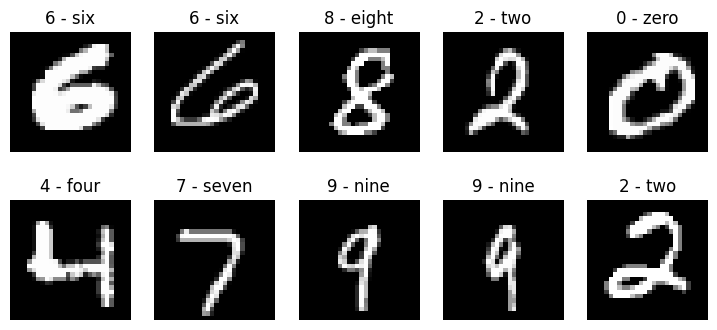

In [2]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
row, col = 2, 5
fig = plt.figure(figsize=(9, 4))

for i in range(1, row * col + 1):
    random_idx = torch.randint(0, len(train_data), [1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(row, col, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [3]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE)

len(train_data), len(train_dataloader), len(test_data), len(test_dataloader)

(60000, 1875, 10000, 313)

## Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MNISTModel(nn.Module):
    def __init__(self, input_channel: int = 1, hidden_units: int = 10, output_channel: int = len(class_names)):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_channel, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, output_channel)
        )
    
    def forward(self, x):
        y = self.classifier(self.block_2(self.block_1(x)))
        return y

model_0 = MNISTModel().to(device)
model_0

MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [5]:
from timeit import default_timer as timer

def print_train_time(start_time: float, end_time: float, device:  torch.device = None):
    
    total_time = end_time - start_time
    print(f"Train time : {total_time:.3f} seconds, on {device}")
    return total_time



In [6]:
def train_step(
        data_loader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        loss_func: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device = None
):
    train_loss, train_acc = 0.0, 0.0
    total_samples = 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        train_preds = model(X)
        loss = loss_func(train_preds, y)
        train_loss += loss
        train_acc += (torch.argmax(train_preds, dim=1) == y).sum().item()
        total_samples += len(y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc = train_acc / total_samples * 100
    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")

In [7]:
def test_step(
        data_loader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        loss_func: torch.nn.Module,
        device: torch.device = None
):
    test_loss, test_acc = 0.0, 0.0
    total_samples = 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_func(test_pred, y).item()
            test_acc += (torch.argmax(test_pred, dim=1) == y.clone()).sum().item()
            total_samples += len(y)
            
    test_loss /= len(data_loader)
    test_acc = test_acc / total_samples * 100
    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n-----------------------------------------------")

In [8]:
start_time_on_cpu = timer()
from tqdm.auto import tqdm

# loss_func & optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

epochs = 5
for epoch in tqdm(range(epochs)):
    train_step(train_dataloader, model_0, loss_func, optimizer, device="cpu")
    test_step(test_dataloader, model_0, loss_func, device="cpu")

end_time_on_cpu = timer()
print_train_time(start_time_on_cpu, end_time_on_cpu, device="cpu")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.39775 | Train Accuracy: 86.18%
Test Loss: 0.07030 | Test Accuracy: 97.59%
-----------------------------------------------
Epoch: 1 | Train loss: 0.07381 | Train Accuracy: 97.75%
Test Loss: 0.05413 | Test Accuracy: 98.24%
-----------------------------------------------
Epoch: 2 | Train loss: 0.05567 | Train Accuracy: 98.29%
Test Loss: 0.05053 | Test Accuracy: 98.31%
-----------------------------------------------
Epoch: 3 | Train loss: 0.04779 | Train Accuracy: 98.50%
Test Loss: 0.04021 | Test Accuracy: 98.57%
-----------------------------------------------
Epoch: 4 | Train loss: 0.04223 | Train Accuracy: 98.70%
Test Loss: 0.04199 | Test Accuracy: 98.67%
-----------------------------------------------
Train time : 43.107 seconds, on cpu


43.10714960000041

In [9]:
start_time_on_gpu = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    train_step(train_dataloader, model_0, loss_func, optimizer, device)
    test_step(test_dataloader, model_0, loss_func, device)

end_time_on_gpu = timer()
print_train_time(start_time_on_gpu, end_time_on_gpu, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.03876 | Train Accuracy: 98.78%
Test Loss: 0.04014 | Test Accuracy: 98.62%
-----------------------------------------------
Epoch: 1 | Train loss: 0.03472 | Train Accuracy: 98.91%
Test Loss: 0.03678 | Test Accuracy: 98.93%
-----------------------------------------------
Epoch: 2 | Train loss: 0.03194 | Train Accuracy: 99.00%
Test Loss: 0.03714 | Test Accuracy: 98.83%
-----------------------------------------------
Epoch: 3 | Train loss: 0.03025 | Train Accuracy: 99.02%
Test Loss: 0.03329 | Test Accuracy: 98.91%
-----------------------------------------------
Epoch: 4 | Train loss: 0.02716 | Train Accuracy: 99.10%
Test Loss: 0.03652 | Test Accuracy: 98.87%
-----------------------------------------------
Train time : 32.588 seconds, on cuda


32.588342699999885

## Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

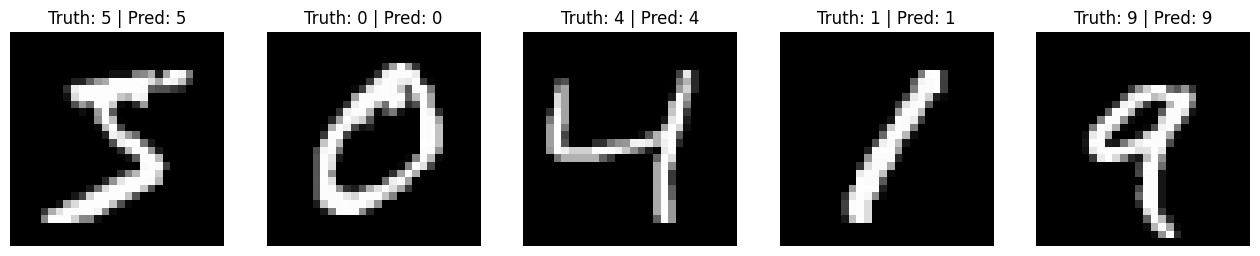

In [10]:
row, col = 1, 5
fig = plt.figure(figsize=(16, 4))
for i in range(1, row * col + 1):
    image, label = train_data[i-1][0], train_data[i-1][1]
    pred_logits = model_0(image.unsqueeze(dim=0).to(device))
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)
    fig.add_subplot(row, col, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Truth: {label} | Pred: {pred_label.cpu().item()}")
    plt.axis(False)

## Plot a confusion matrix comparing your model's predictions to the truth labels.

In [11]:
from tqdm.auto import tqdm
model_0.eval()
y_pred = []
with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_dataloader)):
        X, y = X.to(device), y.to(device)
        
        pred_logits = model_0(X)
        pred_label = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)
        y_pred.append(pred_label)
    y_pred = torch.cat(y_pred).cpu()
len(y_pred)

0it [00:00, ?it/s]

10000

In [12]:
test_data.targets[:10], y_pred[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

In [13]:
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


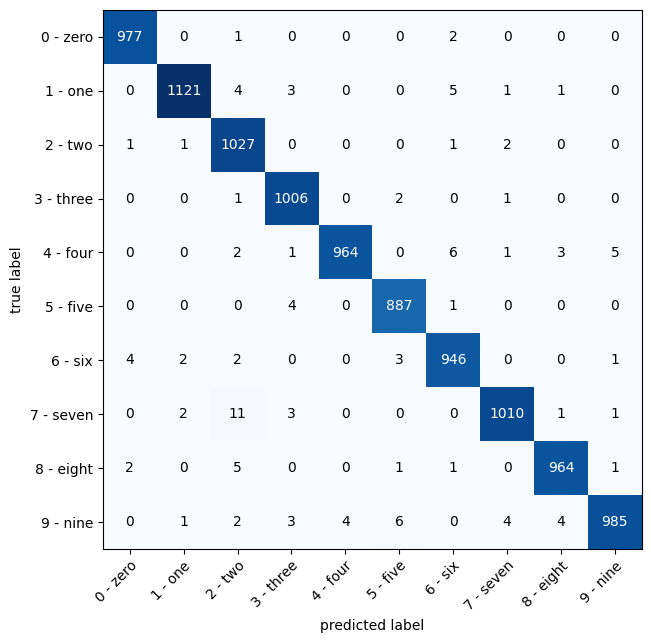

In [14]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred, target=test_data.targets)

fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10, 7)
)

##  Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [15]:
random_tensor = torch.rand((1, 3, 64, 64))
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [16]:
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=64,
    kernel_size=3,
    stride=2,
    padding=1
)

print(f"Random tensor original shape: {random_tensor.shape}")
random_tensor_through_conv_layer = conv_layer(random_tensor)
print(f"Random tensor through conv layer: {random_tensor_through_conv_layer.shape}")

Random tensor original shape: torch.Size([1, 3, 64, 64])
Random tensor through conv layer: torch.Size([1, 64, 32, 32])


## Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [18]:
fashion_train_data = datasets.FashionMNIST(
    root="fashion_data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

fashion_test_data = datasets.FashionMNIST(
    root="fashion_data",
    train=False,
    transform=ToTensor(),
    download=True
)

len(fashion_train_data), len(fashion_test_data)

(60000, 10000)

In [19]:
fashion_class_names = fashion_train_data.classes
fashion_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [20]:
fashion_train_dataloader = DataLoader(fashion_train_data, batch_size=BATCH_SIZE, shuffle=True)
fashion_test_dataloader = DataLoader(fashion_test_data, batch_size=BATCH_SIZE)

len(fashion_train_dataloader), len(fashion_test_dataloader)

(1875, 313)

In [21]:
model_fashion = MNISTModel().to(device)
model_fashion

MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [22]:
loss_func_fashion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fashion.parameters(), lr=1e-2)

In [23]:
epochs = 5
for epoch in tqdm(range(epochs)):
    train_step(fashion_train_dataloader, model_fashion, loss_func, optimizer, device)
    test_step(fashion_test_dataloader, model_fashion, loss_func, device)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.95424 | Train Accuracy: 65.59%
Test Loss: 0.57005 | Test Accuracy: 79.29%
-----------------------------------------------
Epoch: 1 | Train loss: 0.52334 | Train Accuracy: 80.85%
Test Loss: 0.48310 | Test Accuracy: 82.66%
-----------------------------------------------
Epoch: 2 | Train loss: 0.45092 | Train Accuracy: 83.63%
Test Loss: 0.51369 | Test Accuracy: 80.51%
-----------------------------------------------
Epoch: 3 | Train loss: 0.40910 | Train Accuracy: 85.29%
Test Loss: 0.41716 | Test Accuracy: 85.17%
-----------------------------------------------
Epoch: 4 | Train loss: 0.38104 | Train Accuracy: 86.26%
Test Loss: 0.40390 | Test Accuracy: 85.36%
-----------------------------------------------


In [24]:
fashion_test_preds = []
model_fashion.eval()
with torch.inference_mode():
    for X_test, y_test in tqdm(fashion_test_dataloader):
        pred_logits = model_fashion(X_test.to(device))
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
        fashion_test_preds.append(pred_label)
    
    fashion_test_preds = torch.cat(fashion_test_preds).cpu()
fashion_test_preds[:10], len(fashion_test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [25]:
import numpy as np
wrong_pred_indexes = np.where(fashion_test_preds != fashion_test_data.targets)[0]
len(wrong_pred_indexes), wrong_pred_indexes

(1464, array([  12,   17,   21, ..., 9977, 9979, 9985], dtype=int64))

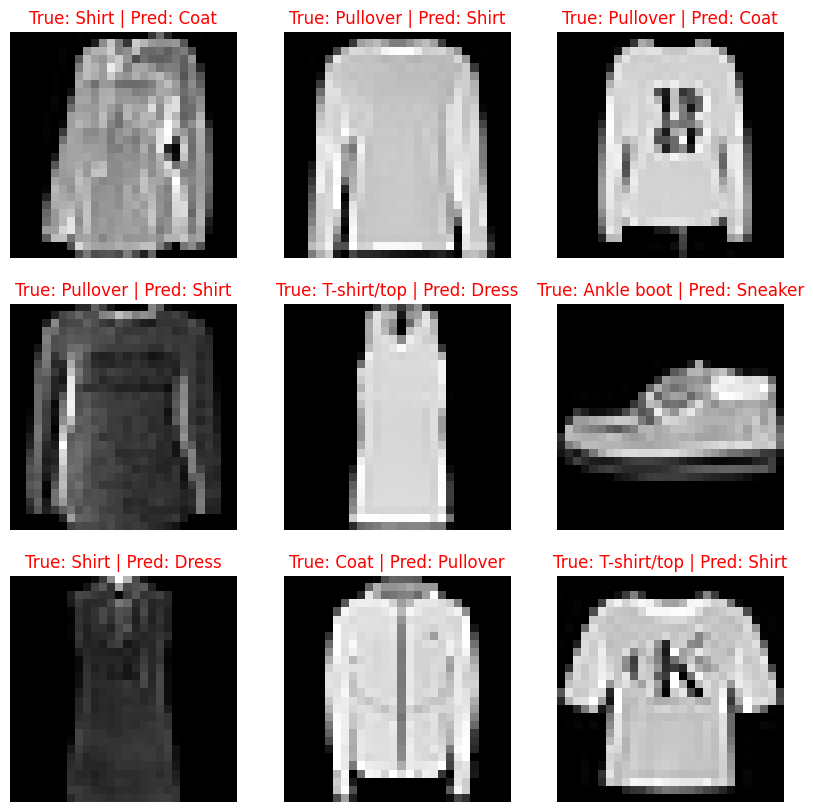

In [26]:
import random
random_selection = random.sample(list(wrong_pred_indexes), k = 9)
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_selection):
    true_label = fashion_class_names[fashion_test_data[idx][1]]
    pred_label = fashion_class_names[fashion_test_preds[idx]]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(fashion_test_data[idx][0].squeeze(), cmap="gray")
    plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
    plt.axis(False)